In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
from random import random

In [5]:
def σ(z):
    return 1/(1 + np.e**(-z))
def σ_prime(z):
    return np.e**(z) / (np.e**z + 1)**2

In [6]:
def Plot(fn, *args, **kwargs):
    argLength = len(args);
    if argLength == 1:
        start = args[0][0]
        end = args[0][1]
        points = None
        try: 
            points = args[0][2]
        except:
            pass
        if not points: points = 30
        xs = linspace(start, end, points);
        plot(xs, list(map(fn, xs)), **kwargs);

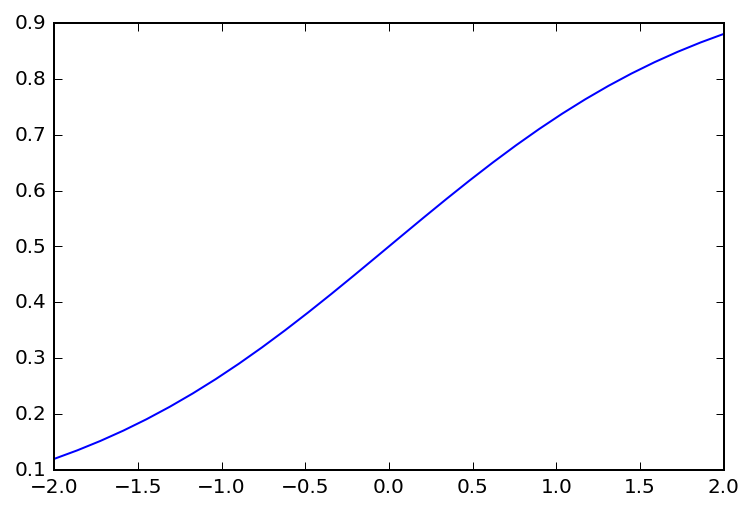

In [7]:
Plot(σ, [-2, 2])

In [8]:
y = lambda neuron, input: neuron[0] * input + neuron[1]
α = lambda neuron, input: σ(y(neuron, input))
partial_w = lambda neuron, input: \
    σ_prime(y(neuron, input)) * input
partial_y = lambda neuron, input: \
    σ_prime(y(neuron, input))

In [9]:
class Neuron():
    def __init__(self, neuron):
        self.neuron = neuron
        
    def output(self, input):
        return α(self.neuron, input)
    
    def set_η(self, η):
        self.η = η
        
    def train(self, input, target, η=None):
        result = self.output(input);
        δ = result - target
        p_w = partial_w(self.neuron, input)
        p_y = partial_y(self.neuron, input)
        
        gradient = np.array([p_w, p_y])#/np.sqrt(p_w**2 + p_y**2)
        if η is None:
            η = self.η
        self.neuron = - η * δ * gradient + self.neuron;
        return result

In [22]:
class Network():
    def __init__(self, shape, parameters=None):
        self.shape = shape;
        self.zs = {};
        self.αs = {};
        
        self.weights = {};
        self.biases = {};
        
        self.δs = {};
        self.partial_ws = {};
        self.partial_biases = {};
        
        if parameters is not None:
            weights, biases = parameters;
            self.weights = weights;
            self.biases = biases;
        else:
            for i in range(1, len(shape)):
                self.create_network(i, shape[i])
        
    def create_network(self, ind, size):
        if ind is 0: return;
        self.weights[ind] = np.random.random(self.shape[ind-1:ind+1][::-1]) - 0.5
        self.biases[ind] = np.random.random(self.shape[ind]) - 0.5
        
    def output(self, input=None):
        if input is not None:
            self.forward_pass(input);
        return self.αs[len(self.shape) - 1]
    
    def set_η(self, η=None):
        if η is None: return
        self.η = η
        
    def train(self, input, target, η=None):
        if η is None:
            η = self.η        
        self.forward_pass(input)
        self.back_propagation(target)
        self.gradient_descent(η)
        
    def forward_pass(self, input):
        # forward passing
        self.αs[0] = input;
        for i in range(1, len(self.shape)):
            self.forward_pass_layer(i);
    
    def back_propagation(self, target):
        # back-propagation
        ind_last = len(self.shape) - 1
        self.δs[ind_last] = σ_prime(self.zs[ind_last]) * \
            (self.αs[ind_last] - target);
        for i in list(range(1, len(self.shape)))[::-1]:
            self.back_propagation_layer(i)
    
    def gradient_descent(self, η):     
        # gradient descent
        for i in range(1, len(self.shape)):
            self.gradient_descent_layer(i, η)
        
    def forward_pass_layer(self, ind):
        """ind is the index of the current network"""
        self.zs[ind] = self.biases[ind] + \
            np.tensordot(self.weights[ind], self.αs[ind - 1], axes=1)
        self.αs[ind] = σ(self.zs[ind])
        
    def back_propagation_layer(self, ind):
        """ind \in [len(self.shape) - 1, 1]"""
        if ind > 1:
            self.δs[ind - 1] = σ_prime(self.zs[ind-1]) * \
                np.tensordot(self.δs[ind], self.weights[ind], axes=1)
        self.partial_ws[ind] = np.tensordot(self.δs[ind], self.αs[ind - 1], axes=0)
        
    def gradient_descent_layer(self, ind, η):
        """ind \in [1, ...len(shape) - 1]"""
        self.weights[ind] = self.weights[ind] - η * self.partial_ws[ind]
        self.biases[ind] = self.biases[ind] - η * self.δs[ind]

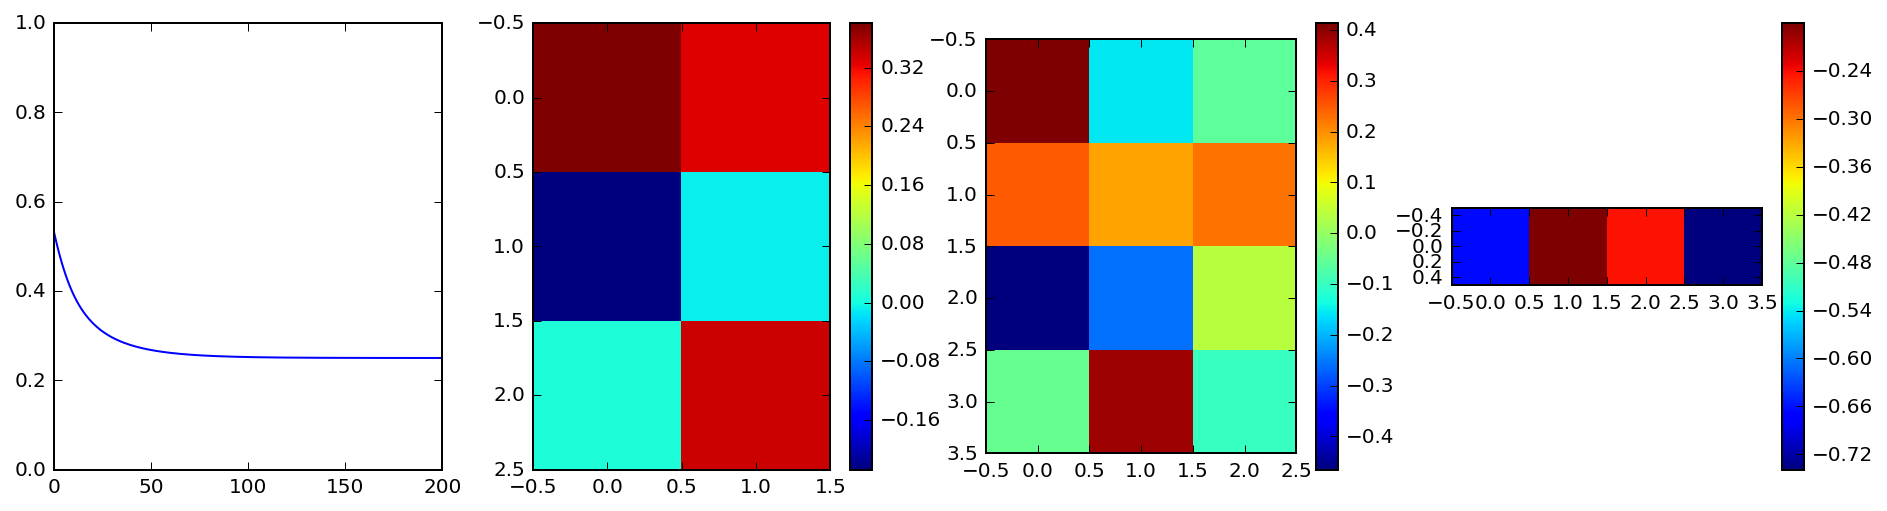

In [23]:
# train as a simple neuron
nw = Network([1, 2, 3, 4, 1])

outputs = []
for i in range(200):

    x = 1; target = 0.25
    nw.train(np.array([x]), np.array([target]), η = 0.5)
    outputs.append(nw.output()[0])

figure(figsize=(16, 4))
subplot(141)
plot(outputs)
ylim(0, 1)
subplot(142)
imshow(nw.weights[2], interpolation='none', aspect=1);colorbar()
subplot(143)
imshow(nw.weights[3], interpolation='none', aspect=1);colorbar()
subplot(144)
imshow(nw.weights[4], interpolation='none', aspect=1);colorbar()

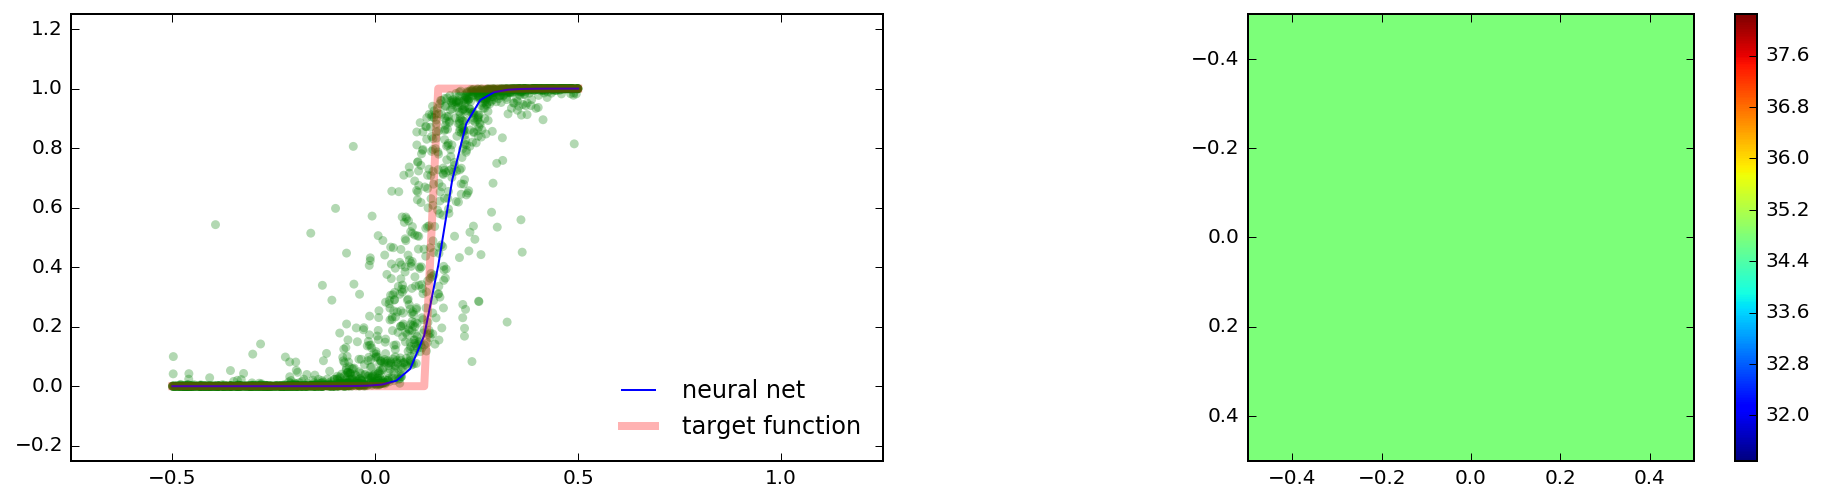

In [24]:
# train as a simple neuron
target_func = lambda x: [0] if x < 0.125 else [1]
nw = Network([1, 1])

figure(figsize=(16, 4))
subplot(121)

for i in range(2000):
    x = np.array([random() - 0.5])    
    nw.train(x, target_func( x ), η = 20)
    scatter(x, nw.output(), color="green", alpha=0.3, edgecolor='none')

Plot(lambda x: nw.output([x])[0], [-0.5, 0.5], label="neural net")
Plot(lambda x: target_func(x), [-0.5, 0.5], color='r', linewidth=4, alpha=0.3, label="target function")
xlim(-0.75, 1.25)
ylim(-0.25, 1.25)
legend(loc=4, frameon=False)

subplot(122)
imshow(nw.weights[1], interpolation='none', aspect=1);colorbar();
# subplot(143)
# imshow(nw.weights[2], interpolation='none', aspect=1);colorbar()
# subplot(144)
# imshow(nw.weights[3], interpolation='none', aspect=1);colorbar()


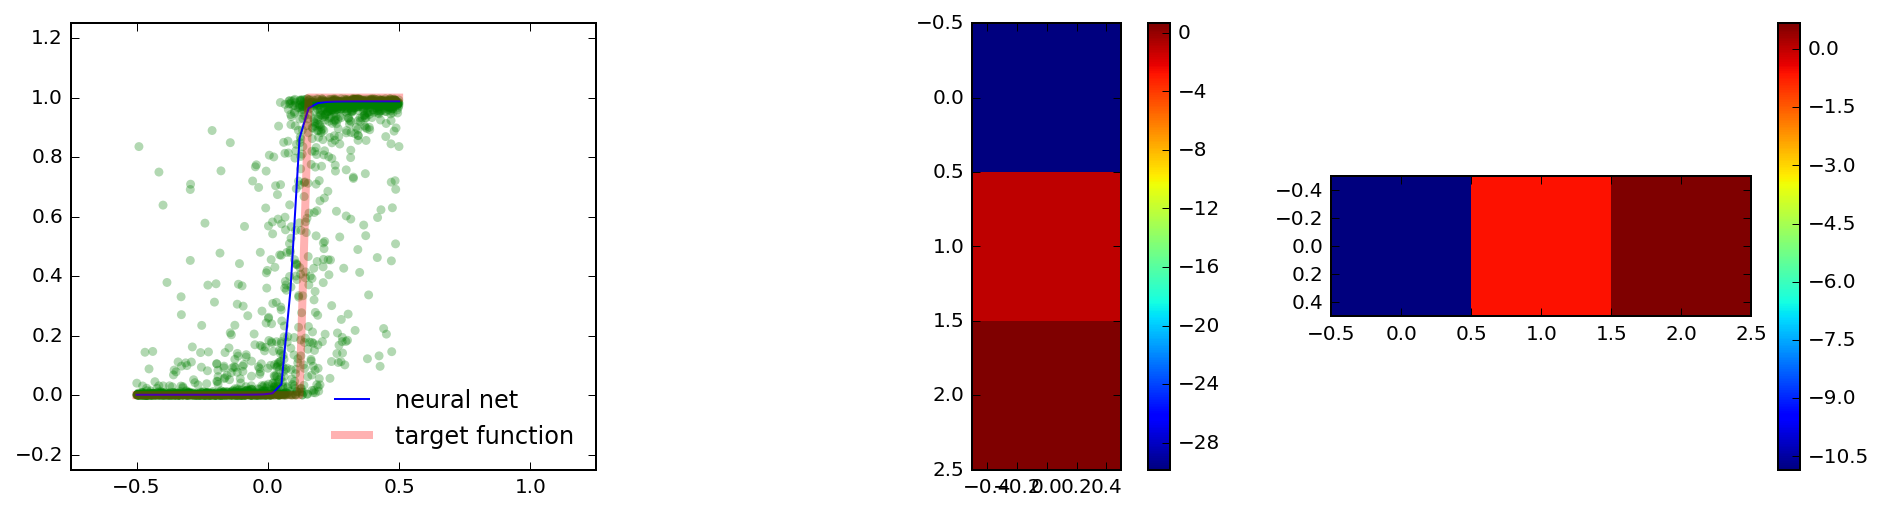

In [25]:
# train as a simple neuron
target_func = lambda x: [0] if x < 0.125 else [1]
nw = Network([1, 3,  1])

figure(figsize=(16, 4))
subplot(131)

for i in range(2000):
    x = np.array([random() - 0.5])    
    nw.train(x, target_func( x ), η = 10)
    scatter(x, nw.output(), color="green", alpha=0.3, edgecolor='none')

Plot(lambda x: nw.output([x])[0], [-0.5, 0.5], label="neural net")
Plot(lambda x: target_func(x), [-0.5, 0.5], color='r', linewidth=4, alpha=0.3, label="target function")
xlim(-0.75, 1.25)
ylim(-0.25, 1.25)
legend(loc=4, frameon=False)

subplot(132)
imshow(nw.weights[1], interpolation='none', aspect=1);colorbar();
subplot(133)
imshow(nw.weights[2], interpolation='none', aspect=1);colorbar()
# subplot(144)
# imshow(nw.weights[3], interpolation='none', aspect=1);colorbar()

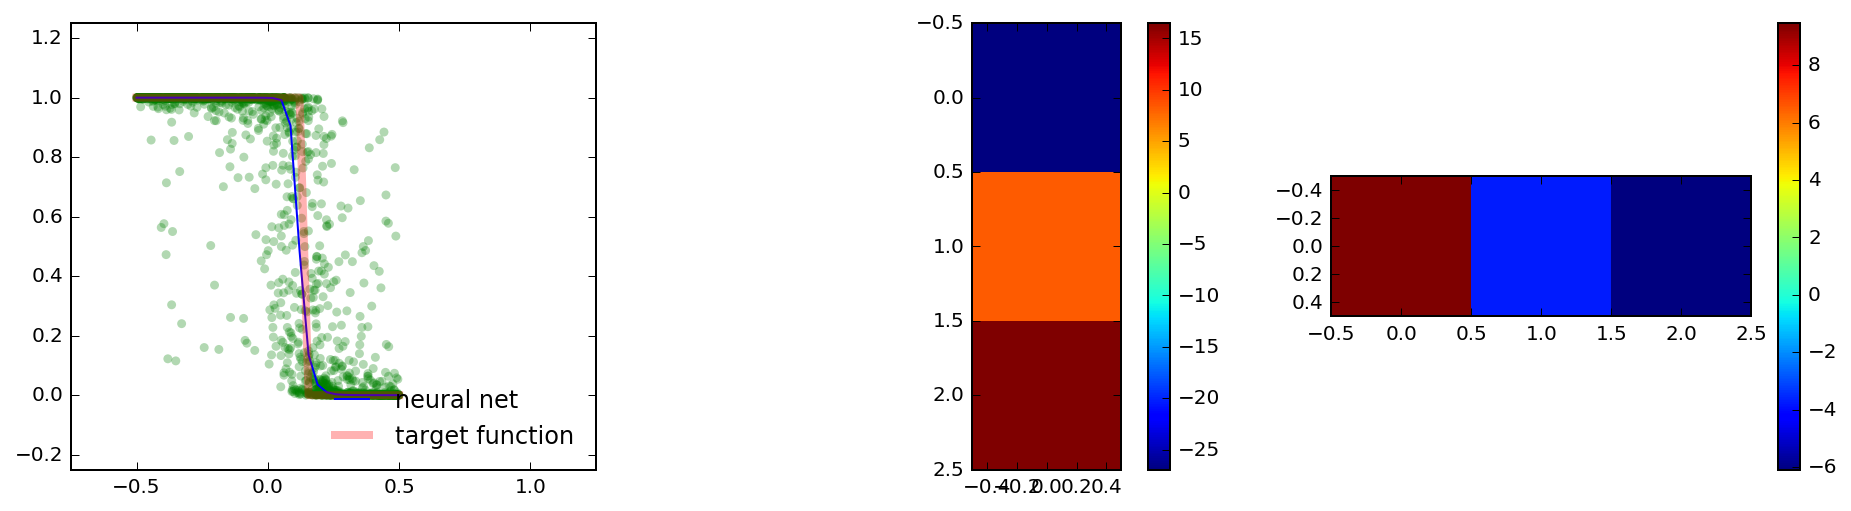

In [26]:
# train as a simple neuron
target_func = lambda x: [1] if x < 0.125 else [0]
nw = Network([1, 3,  1])

figure(figsize=(16, 4))
subplot(131)

for i in range(2000):
    x = np.array([random() - 0.5])    
    nw.train(x, target_func( x ), η = 10)
    scatter(x, nw.output(), color="green", alpha=0.3, edgecolor='none')

Plot(lambda x: nw.output([x])[0], [-0.5, 0.5], label="neural net")
Plot(lambda x: target_func(x), [-0.5, 0.5], color='r', linewidth=4, alpha=0.3, label="target function")
xlim(-0.75, 1.25)
ylim(-0.25, 1.25)
legend(loc=4, frameon=False)

subplot(132)
imshow(nw.weights[1], interpolation='none', aspect=1);colorbar();
subplot(133)
imshow(nw.weights[2], interpolation='none', aspect=1);colorbar()
# subplot(144)
# imshow(nw.weights[3], interpolation='none', aspect=1);colorbar()